In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from pyHalo.plotting_routines import plot_concentration_mass_relation, plot_halo_mass_function

## Warm dark matter (WDM)

pyHalo currently supports a WDM preset model. The default halo mass funciton is detailed by Lovell et al. (2020). https://ui.adsabs.harvard.edu/abs/2020ApJ...897..147L/abstract 

The key parameters for this model are the same as those for cold dark matter (CDM), with the addition of a characteristic mass scale below which both halo abundance and concentration becomes suppressed, relative to CDM. 

1) log_mc: the logarithm (base 10) of the halo mass scale below which halo abundance and structure becomes suppressed

As demonstrated below, the form of the concentration-mass relation and the cutoff in the mass function can be altered by passing additional keyword arguments. 

realization contains 6652 halos.


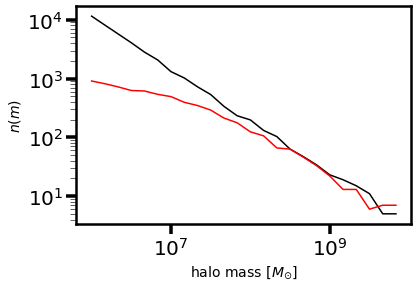

In [2]:
from pyHalo.preset_models import WDM, CDM

zlens, zsource = 0.5, 2.0
kwargs_concentration_model_subhalos = {'scatter': True}
kwargs_concentration_model_fieldhalos = {'scatter': True}
cone_opening_angle_arcsec = 8
realizationCDM = CDM(zlens, zsource, cone_opening_angle_arcsec=cone_opening_angle_arcsec, geometry_type='CYLINDER', 
                     sigma_sub=0.1, log_mlow=6.0)
realizationWDM = WDM(zlens, zsource, log_mc=7., cone_opening_angle_arcsec=cone_opening_angle_arcsec, log_mlow=6.0,
                     geometry_type='CYLINDER', sigma_sub=0.1,
                    kwargs_concentration_model_subhalos=kwargs_concentration_model_subhalos,
                    kwargs_concentration_model_fieldhalos=kwargs_concentration_model_fieldhalos)
print('realization contains '+str(len(realizationWDM.halos))+' halos.')

fig = plt.figure(1)
ax = plt.subplot(111)
plot_halo_mass_function(realizationCDM, color='k', ax=ax)
plot_halo_mass_function(realizationWDM, color='r', ax=ax)

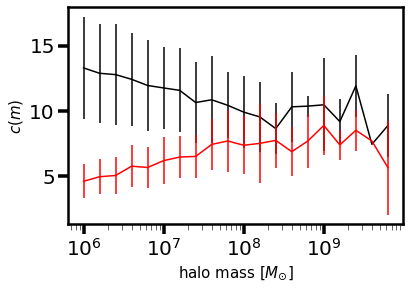

In [3]:
fig = plt.figure(1)
ax = plt.subplot(111)
plot_concentration_mass_relation(realizationCDM, z_eval=[0.51, 2.0], color='k', ax=ax, show_errorbars=True)
plot_concentration_mass_relation(realizationWDM, z_eval=[0.51, 2.0], color='r', ax=ax, show_errorbars=True)

### Modfied turnovers in the concentration-mass relation and mass function

You can change the implementation of the turnover by specifying certain keyword arguments. These will override the default settings. 

The default mass function setting has a turnover of the form 

\begin{equation}
\frac{dN_{\rm{WDM}}}{dm} = \frac{dN_{\rm{CDM}}}{dm} \left(1 + a_{\rm{wdm}} \left(\frac{m_c}{m}\right)^{b_{\rm{wdm}}}\right)^{c_{\rm{wdm}}}
\end{equation}

The defalt concentration-mass relation turnover is of the form given by Bose et al. (2016)

\begin{equation}
c_{\rm{WDM}}\left(m\right) = c_{\rm{CDM}}\left(m\right) \left(1+z\right)^{\beta\left(z\right)} \left(1+c_{\rm{scale}}\left(\frac{m_c}{m}\right)^{c_{\rm{powerinner}}}\right)^{c_{\rm{power}}}
\end{equation}

Other options are available. Check out the classes in pyHalo.rendering.MassFunctions

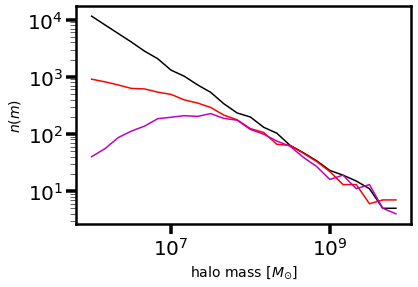

In [4]:
kwargs_concentration_model_subhalos = {'scatter': False, 'c_scale': 0.1, 'c_power_inner': 1.0, 'c_power': -3.0}
kwargs_concentration_model_fieldhalos = {'scatter': False, 'c_scale': 0.1, 'c_power_inner': 1.0, 'c_power': -3.0}

kwargs_mass_function_model_subhalos = {'a_wdm': 2.0, 'b_wdm': 1.0, 'c_wdm': -2.0}
kwargs_mass_function_model_fieldhalos = {'a_wdm': 2.0, 'b_wdm': 1.0, 'c_wdm': -2.0}

realizationWDM_modified = WDM(zlens, zsource, log_mc=7., cone_opening_angle_arcsec=cone_opening_angle_arcsec, 
                              log_mlow=6.0, geometry_type='CYLINDER', sigma_sub=0.1,
                              concentration_model_subhalos='WDM_POLYNOMIAL',
                              concentration_model_fieldhalos='WDM_POLYNOMIAL',
                    kwargs_concentration_model_subhalos=kwargs_concentration_model_subhalos,
                    kwargs_concentration_model_fieldhalos=kwargs_concentration_model_fieldhalos,
                              mass_function_model_subhalos='POWER_LAW_TURNOVER_SHMF',
                              mass_function_model_fieldhalos='POWER_LAW_TURNOVER',
                             kwargs_mass_function_subhalos=kwargs_mass_function_model_subhalos,
                             kwargs_mass_function_fieldhalos=kwargs_mass_function_model_fieldhalos)

fig = plt.figure(1)
ax = plt.subplot(111)
plot_halo_mass_function(realizationCDM, color='k', ax=ax)
plot_halo_mass_function(realizationWDM, color='r', ax=ax)
plot_halo_mass_function(realizationWDM_modified, color='m', ax=ax)

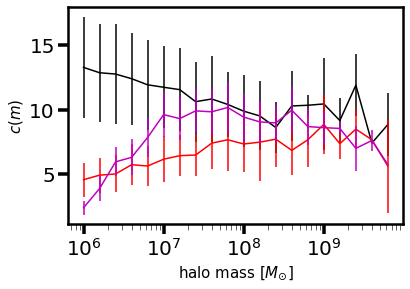

In [5]:
fig = plt.figure(1)
ax = plt.subplot(111)
plot_concentration_mass_relation(realizationCDM, z_eval=[0.51, 2.0], color='k', ax=ax, show_errorbars=True)
plot_concentration_mass_relation(realizationWDM, z_eval=[0.51, 2.0], color='r', ax=ax, show_errorbars=True)
plot_concentration_mass_relation(realizationWDM_modified, z_eval=[0.51, 2.0], color='m', ax=ax, show_errorbars=True)

### Stucker et al. 2021 models https://arxiv.org/pdf/2109.09760.pdf

These models are parameterized in terms of the half-mode mass scale and the logarithmic derivative of the transfer function at this scale. The mass function is computed using the prescription by Stucker et al. (2021) and halo concentrations are computed based on their formation time (e.g. Schneider et al. 2012, Ludlow et al. 2016) 

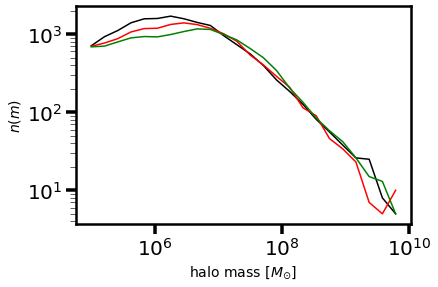

In [17]:
from pyHalo.preset_models import WDMGeneral
dlogT_dlogk = 1.0 # absolute value
wdm_stucker1 = WDMGeneral(zlens, zsource, log_mc=7., dlogT_dlogk=dlogT_dlogk,LOS_normalization=2.0,
                         cone_opening_angle_arcsec=cone_opening_angle_arcsec, log_mlow=5.0,
                     geometry_type='CYLINDER', sigma_sub=0.1)
dlogT_dlogk = 2.
wdm_stucker2 = WDMGeneral(zlens, zsource, log_mc=7., dlogT_dlogk=dlogT_dlogk,LOS_normalization=2.0,
                         cone_opening_angle_arcsec=cone_opening_angle_arcsec, log_mlow=5.0,
                     geometry_type='CYLINDER', sigma_sub=0.1)
dlogT_dlogk = 3.3
wdm_stucker3 = WDMGeneral(zlens, zsource, log_mc=7., dlogT_dlogk=dlogT_dlogk,
                         cone_opening_angle_arcsec=cone_opening_angle_arcsec, log_mlow=5.0,LOS_normalization=2.0,
                     geometry_type='CYLINDER', sigma_sub=0.1)

fig = plt.figure(1)
ax = plt.subplot(111)
kwargs_plot = {'linestyle': '-'}
plot_halo_mass_function(wdm_stucker1, color='k', ax=ax, kwargs_plot=kwargs_plot, log_mlow=5.0)
kwargs_plot = {'linestyle': '-'}
plot_halo_mass_function(wdm_stucker2, color='r', ax=ax, kwargs_plot=kwargs_plot, log_mlow=5.0)
kwargs_plot = {'linestyle': '-'}
plot_halo_mass_function(wdm_stucker3, color='g', ax=ax, kwargs_plot=kwargs_plot, log_mlow=5.0)

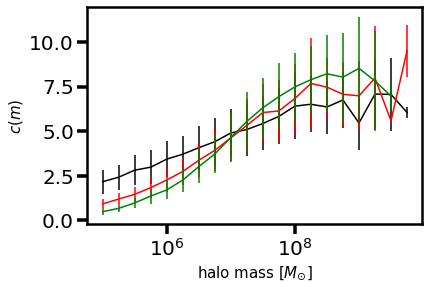

In [19]:
fig = plt.figure(1)
ax = plt.subplot(111)
plot_concentration_mass_relation(wdm_stucker1, z_eval=[0.51, 2.0], color='k', ax=ax, show_errorbars=True,
                                log_mlow=5.0)
plot_concentration_mass_relation(wdm_stucker2, z_eval=[0.51, 2.0], color='r', ax=ax, show_errorbars=True,
                                log_mlow=5.0)
plot_concentration_mass_relation(wdm_stucker3, z_eval=[0.51, 2.0], color='g', ax=ax, show_errorbars=True,
                                log_mlow=5.0)